In [2]:
library(dplyr)
library(parallel)
library(stringr)

reprocess_switch=0#0 or 1. 1 means to recreate all reach and node products following some change in processing. 
#0 means to just append to existing dataframes
process_PTs=1 # switch. do you want to deal with PTs and all downstream processing?
process_airborne =1 #swtich

# hubname='UNC'
# rivername='WK'
# continent='oc'
# PT_key_file= 'SWOTCalVal_WK_KEY_20230331_20230507_1.csv' #WK
# utm_zone='58 +south'#WK='58 +south'

# hubname='UNC'
# rivername='PY'
# continent='na'
# utm_zone=6 

# hubname='UNC'
# rivername='YR'
# continent='na'
# utm_zone=6 

# hubname='UMass'
# rivername='CR'
# continent='na'
# PT_key_file=c('SWOTCalVal_CR_Key_20230322_20230614.csv',
#               'SWOTCalVal_CR_Key_20230516_20230613.csv') #CT
# utm_zone=18 #Ct= 18

# hubname='CU'
# rivername='WM'
# continent='na'
# PT_key_file= c('SWOTCalVal_WM_KEY_20230326_20230510.csv',
#                'SWOTCalVal_WM_KEY_20230509_20230601.csv',
#               'SWOTCalVal_WM_KEY_20230601_20230707.csv',
#                'SWOTCalVal_WM_KEY_20230601_20230801.csv'   )#WM
# utm_zone=10 #WM= 10

hubname='Brown'
rivername='NS'
continent='na'
PT_key_file= 'SWOTCalVal_NS_KEY_20230525_20230613.csv' #WM
utm_zone=13 #NS= 13


reach_end_buffer=500 #m, 'extends' the reach

setwd(paste0('/nas/cee-water/cjgleason/calval/Processed data/',hubname,'/'))
working_dir=(paste0('/nas/cee-water/cjgleason/calval/Processed data/',hubname,'/'))
domain_file=paste0(rivername,'_domain.csv')
paste0('/nas/cee-water/cjgleason/calval/Processed data/',hubname,'/')

#PT paths---------
PT_data_directory=paste0('/nas/cee-water/cjgleason/calval/xml_scripts/',hubname,'/Munged/')

#--------------------------------------------------
#drift paths------------------------------------------
GNSS_drift_data_directory=paste0('From Andy/',hubname,'_netCDFs/')
if(reprocess_switch==1){
    
    drift_string= paste0('Munged drifts/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'))
    PT_string =paste0('Munged PT/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'))
    reachnode_string= paste0('Data frames/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'))
    node_string =paste0('Data frames/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'),'/node')
    reach_string=paste0('Data frames/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'),'/reach')
    flagged_PT_output_directory=paste0('Flagged PT/','reprocessed_',  str_replace_all(as.character(Sys.Date()),'\\-','_'))
    
    #check if we've already reprocessed today
    if (dir.exists(drift_string)){
        #if we have, then use that as the output and clear the files in the drift directory
        unlink(drift_string, recursive = TRUE)
        unlink(PT_string,recursive = TRUE)
        unlink(flagged_PT_output_directory,recursive = TRUE)
        dir.create(drift_string)
        dir.create(flagged_PT_output_directory)
        dir.create(PT_string)
        QA_QC_drift_output_directory=paste0(drift_string,'/')
        QA_QC_PT_output_directory=paste0(PT_string,'/')
        reachnode_output_directory=paste0(reachnode_string,'/')
        flagged_PT_output_directory=paste0(flagged_PT_output_directory,'/')
        } else {
        #if we haven't reprocessed today
        
        dir.create(flagged_PT_output_directory)
    dir.create(drift_string)
    dir.create(PT_string)
    dir.create(reachnode_string)
    dir.create(node_string)
    dir.create(reach_string)
        
    flagged_PT_output_directory=paste0(flagged_PT_output_directory,'/')
    QA_QC_drift_output_directory=paste0(drift_string,'/')
    reachnode_output_directory=paste0(reachnode_string,'/')
    QA_QC_PT_output_directory=paste0(PT_string,'/')
    }
    
    } else { #we aren't reprocessing. find the most recent folders to use
    
folderlist= list.files('Munged drifts',full.names = TRUE)
    
foldertimes=file.info(folderlist)%>%
 mutate(mintime= Sys.time()-mtime) %>%
 filter(mintime== min(mintime)) 
    
QA_QC_drift_output_directory=paste0(row.names(foldertimes),'/')  
    
folderlist2= list.files('Data frames',full.names = TRUE)
    
foldertimes2=file.info(folderlist2)%>%
 mutate(mintime= Sys.time()-mtime) %>%
 filter(mintime== min(mintime)) 
    
reachnode_output_directory=paste0(row.names(foldertimes2),'/')
    
folderlist3= list.files('Munged PT',full.names = TRUE)
    
foldertimes3=file.info(folderlist3)%>%
 mutate(mintime= Sys.time()-mtime) %>%
 filter(mintime== min(mintime))  
    
QA_QC_PT_output_directory=paste0(row.names(foldertimes3),'/') 
    
folderlist4= list.files('Flagged PT',full.names = TRUE)
    
foldertimes4=file.info(folderlist4)%>%
 mutate(mintime= Sys.time()-mtime) %>%
 filter(mintime== min(mintime))  
    
flagged_PT_output_directory=paste0(row.names(foldertimes4),'/') 
}

flagged_drift_output_directory='Flagged drifts/'
#--------------------------------------------------

#sword paths----------------------------------------
SWORD_path=paste0('/nas/cee-water/cjgleason/calval/SWORD_15/netcdf/',continent,
                  '_sword_v15.nc')
#------------------------------

image_directory=paste0('/nas/cee-water/cjgleason/calval/cnes_watermasks/fromCNES_20230724/',rivername,'/extracteo/') 
print(image_directory)

[1] "/nas/cee-water/cjgleason/calval/Processed data/Brown/"

[1] "/nas/cee-water/cjgleason/calval/cnes_watermasks/fromCNES_20230724/NS/extracteo/"


In [2]:
QA_QC_drift_output_directory
QA_QC_PT_output_directory
reachnode_output_directory
flagged_PT_output_directory


[1] "Munged drifts/reprocessed_2023_08_24/"

[1] "Munged PT/reprocessed_2023_08_24/"

[1] "Data frames/reprocessed_2023_08_24/"

[1] "Flagged PT/reprocessed_2023_08_24/"

In [15]:
#create dataframes from drifts---------------------------------------------------------
#pull filename before the .csv
source('/nas/cee-water/cjgleason/calval_toolbox/R code/create_GNSS_dataframe.R')
raw_GNSS=sub( "\\..*","", list.files(GNSS_drift_data_directory,recursive=TRUE))
raw_GNSS_river=which(!is.na(do.call(rbind,lapply(raw_GNSS,str_match,rivername))))
raw_GNSS=raw_GNSS[raw_GNSS_river]

#pull filename before the second _
QA_QC_drifts=sub( "\\..*","",list.files(QA_QC_drift_output_directory))
flagged_drifts=sub("\\..*","",list.files(flagged_drift_output_directory))
#what raw drift data have not been munged
unmunged_drifts=setdiff(raw_GNSS,c(flagged_drifts,QA_QC_drifts))

#open the key files   
if(rivername=='WK'){
read_keys=function(keyfile){
   this_key= read.csv(keyfile,stringsAsFactors=FALSE)%>%
    mutate(keyid=keyfile)%>%
    mutate(pt_serial=as.integer(PT_Serial))
    }
    
master_key= do.call(rbind,lapply(PT_key_file,read_keys))}else {master_key=NULL}

for (i in 1:length(unmunged_drifts)){
create_gnss_dataframe(unmunged_drifts[i],
                  gnss_drift_data_directory=GNSS_drift_data_directory,
                  output_directory=QA_QC_drift_output_directory,
                  keyfile= master_key,
                  rivername=  rivername,
                naughty_bin_directory=flagged_drift_output_directory )}


#     cl=makeCluster(44)

    
#   dummy=parLapply(cl=cl,unmunged_drifts,create_gnss_dataframe,
#                   gnss_drift_data_directory=GNSS_drift_data_directory,
#                   output_directory=QA_QC_drift_output_directory)
#   stopCluster(cl)


#-------------------------------------------------

[1] "filename SWOTCalVal_WM_GNSS_L2_Rec3_20230421T163420_20230421T211530_20230426T042740 bonked"


In [6]:
#munge PTs if needed------
source('/nas/cee-water/cjgleason/calval_toolbox/R code/correct_PT_to_GNSS_multikey.R')
if (process_PTs==1){
dist_thresh=150 # 150m
time_thresh= 15*60 #minutes as seconds, centered, so 15 =30 mins total time
GNSS_sd_thresh=0.15 # 15cm how much variance do you want in the GNSS data when it is within the distance threshold?
offset_sd_thresh=0.10 #m, so 10cm. the the PT apparantly shift by more than a cm?
change_thresh_15_min=0.15#m- does it change more than 5cm in 15 minutes? that is a discontinuity in offset

#first, move .csv files with an 'L1' in them over to the PT_data_directory
munged_files= list.files(PT_data_directory,
                         recursive= TRUE)

PT_index=which(!is.na(do.call(rbind,lapply(munged_files,str_match,'PT_L1'))))
PT_files=munged_files[PT_index]
csv_index=which(!is.na(do.call(rbind,lapply(PT_files,str_match,'.csv'))))
raw_PT_files=PT_files[csv_index]

#open the key files   
read_keys=function(keyfile){
   this_key= read.csv(keyfile,stringsAsFactors=FALSE)%>%
    mutate(keyid=keyfile)%>%
    mutate(pt_serial=as.integer(PT_Serial))
    }
    
master_key= do.call(rbind,lapply(PT_key_file,read_keys))
    
#three key info here-
    #1 PTs in the key
    #2 unmunged PTs
    #3 QA QC PTs
    #4 flagged PTs
    
    #3 + 4 are processed files
    
getit_processed=function(inputstring){   
    output=paste(strsplit(inputstring,'_')[[1]][1:8],collapse='_')
    output=sub("\\..*","",output)
}
    
getit_key =function(inputstring){   
    output=paste(c('SWOTCalVal',rivername,'PT','L1',inputstring),collapse='_')
    output=sub("\\..*","",output)
}
    
getit_negative=function(longstring, shortstrings){
    #search for a pattern between one and many strings with partial matches allows
        output=!any(str_detect(longstring,shortstrings)  )
}
    
getit_positive=function(longstring, shortstrings){
    #search for a pattern between one and many strings with partial matches allows
        output=any(str_detect(longstring,shortstrings))  
}
       
processed_files= do.call(rbind,lapply(c(list.files(QA_QC_PT_output_directory),list.files(flagged_PT_output_directory)),getit_processed))
key_files=do.call(rbind,lapply(master_key$Label,getit_key))

    if (is.null(processed_files)){unprocessed_files=raw_PT_files}else{
unprocessed_files=raw_PT_files[do.call(rbind,lapply(raw_PT_files,getit_negative,processed_files))]}
in_key_unprocessed=unprocessed_files[do.call(rbind,lapply(unprocessed_files,getit_positive,key_files))]

# print('raw')
# print(raw_PT_files)
# print('processed')
# print(processed_files)
# print('unprocessed')
# print(unprocessed_files)
# print('unprocessed in key')
# print(in_key_unprocessed)

    
for(thisone in in_key_unprocessed){

        correct_pt_to_gnss_multikey(thisone,
                  master_key=master_key,
                  dist_thresh=dist_thresh,
                  time_thresh=time_thresh,
                  pt_data_directory=PT_data_directory,
                  gnss_drift_data_directory=QA_QC_drift_output_directory,
                  QA_QC_pt_output_directory=QA_QC_PT_output_directory,
                  flagged_pt_output_directory=flagged_PT_output_directory,
                  gnss_sd_thresh=GNSS_sd_thresh,
                  offset_sd_thresh=offset_sd_thresh,
                  change_thresh_15_min=change_thresh_15_min) 
    
 
}
    
    
    
#       cl=makeCluster(20,type='FORK')
#   dummy=parLapply(cl, in_key_unprocessed,correct_pt_to_gnss_multikey,
#                    master_key=master_key,
                  # dist_thresh=dist_thresh,
                  # time_thresh=time_thresh,
                  # pt_data_directory=PT_data_directory,
                  # gnss_drift_data_directory=QA_QC_drift_output_directory,
                  # QA_QC_pt_output_directory=QA_QC_PT_output_directory,
                  # flagged_pt_output_directory=flagged_PT_output_directory,
                  # gnss_sd_thresh=GNSS_sd_thresh,
                  # offset_sd_thresh=offset_sd_thresh,
                  # change_thresh_15_min=change_thresh_15_min) 
#   stopCluster(cl)
    
    
    }#end if process PT
 

[1] "/nas/cee-water/cjgleason/calval/xml_scripts/UMass/Munged/Munged__20230629/SWOTCalVal_CR_PT_L1_PT058_20230403T104500_20230517T173000_20230629T203730.csv"


ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `datetime = as.POSIXct(paste(Date, Time), format =
  "%Y/%m/%d %H:%M:%S")`.
[1mCaused by error in `strptime()`:[22m
[33m![39m input string is too long


In [13]:
#calculate slopes and heights from drifts within nodes and reaches------
SWORD_reach= read.csv(domain_file)
this_river_reach_IDs= as.numeric(unique(SWORD_reach$Reach_ID[!is.na(SWORD_reach$Reach_ID)]))
this_river_node_IDs= as.numeric(unique(SWORD_reach$Node_ID[!is.na(SWORD_reach$Node_ID)]))


source('/nas/cee-water/cjgleason/calval_toolbox/R code/calculate_slope_wse_fromdrift.R')


dummy=calculate_slope_wse_fromdrift(SWORD_path=SWORD_path,
                                    drift_directory=QA_QC_drift_output_directory,
                                    PT_directory=PT_directory,
                                    output_directory=reachnode_output_directory,
                                    this_river_reach_ids=this_river_reach_IDs,
                                    this_river_node_ids=this_river_node_IDs,
                                    utm_zone=utm_zone, 
                                    buffer=reach_end_buffer,
                                    rivername=rivername,
                                    reprocess_switch=reprocess_switch,
                                    core_count=core_count)

[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am return

In [ ]:
# reprocess_switch=1

In [20]:
#calculate slopes and heights from PTs within nodes and reaches----
if (process_PTs==1){
PT_files=paste0(QA_QC_PT_output_directory,list.files(QA_QC_PT_output_directory))
SWORD_reach= read.csv(domain_file)
this_river_reach_IDs= as.numeric(as.character(unique(SWORD_reach$Reach_ID)))
this_river_node_IDs= as.numeric(unique(SWORD_reach$Node_ID[!is.na(SWORD_reach$Node_ID)]))
 
alongstream_error= 0.0001*200 #m error we get from the downstream slope of a reach in a node. This placeholder is a 1e-4 slope over a 200m node
crossstream_error= 0.005 #m error we get from PT not representing cross stream superelevation/noise in a node
measurement_error= 0.001 #m error we get from PT measurement itself 
source('/nas/cee-water/cjgleason/calval_toolbox/R code/calculate_slope_wse_fromPT.R')

read_keys=function(keyfile){
   this_key= read.csv(keyfile,stringsAsFactors=FALSE)%>%
    mutate(keyid=keyfile)%>%
    mutate(pt_serial=as.integer(PT_Serial))
    }
    
master_key= do.call(rbind,lapply(PT_key_file,read_keys))

dummy=calculate_slope_wse_fromPT(keyfile=master_key,
                                 pt_files=PT_files,
                                 SWORD_path=SWORD_path,
                                 SWORD_reach=SWORD_reach,
                                 this_river_reach_ids=this_river_reach_IDs,
                                 this_river_node_ids=this_river_node_IDs,
                                 rivername=rivername,
                                 output_directory= reachnode_output_directory,
                                 alongstream_error=alongstream_error,
                                 crossstream_error=crossstream_error,
                                 measurement_error=measurement_error)
     }
#-----------------------------

[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am return

`summarise()` has grouped output by 'node_id', 'pt_time_UTC'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'node_id', 'pt_time_UTC'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'node_id', 'pt_time_UTC'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'node_id', 'pt_time_UTC'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'node_id', 'pt_time_UTC'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'node_id', 'pt_time_UTC'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'node_id', 'pt_time_UTC'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'node_id', 'pt_time_UTC'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'node_id', 'pt_time_UTC'. You can override
using the `.groups` argument.
`summarise()` has g

# A tibble: 6 × 7
  pt_time_UTC         mean_reach_wse_m reach_id    mean_reach_pt_wse_m
  <chr>                          <dbl> <chr>                     <dbl>
1 2023-04-03 07:00:00             48.2 78220000191                48.2
2 2023-04-03 07:01:00             49.1 78220000191                49.1
3 2023-04-03 07:02:00             49.1 78220000191                49.1
4 2023-04-03 07:03:00             49.1 78220000191                49.1
5 2023-04-03 07:04:00             49.1 78220000191                49.1
6 2023-04-03 07:05:00             49.1 78220000191                49.1
# ℹ 3 more variables: mean_reach_pt_wse_precision_m <dbl>, nodelist <chr>,
#   mean_p_dist_out <dbl>
# A tibble: 6 × 7
  pt_time_UTC         mean_reach_wse_m reach_id    mean_reach_pt_wse_m
  <chr>                          <dbl> <chr>                     <dbl>
1 2023-04-03 07:00:00             50.8 78220000201                50.8
2 2023-04-03 07:15:00             50.8 78220000201                50.8
3 2023-04-0

In [ ]:
#define what drift goes with what SWOT overpass--------------------
#SWOT_L2_HR_RiverSP_<FileIdentifier>_<CycleID>_<PassID>_<ContinentID>_<RangeBeginningDateTime>_<RangeEndingDateTime>_<CRID>_<ProductCounter>.<extension> 

if (process_PTs ==1){
passfile=paste0('/nas/cee-water/cjgleason/calval/Processed data/riversp_list_clean_',rivername,'_20230726.txt')

 
passnames=read.delim(passfile,header=F)$V1
 
  
time_threshold_sec= 120*60 #two hour
wse_threshold_m=0.05 #within 5cm
distance_threshold_m =200 #within 200m

if (!dir.exists(paste0('Matched_drifts/','processed_',str_replace_all(as.character(Sys.Date()),'\\-','_')))){
    dir.create(paste0('Matched_drifts/','processed_',str_replace_all(as.character(Sys.Date()),'\\-','_')))}


matched_output_directory= paste0('Matched_drifts/','processed_',str_replace_all(as.character(Sys.Date()),'\\-','_'),'/')
munged_drift_directory= QA_QC_drift_output_directory
munged_pt_directory=paste0(working_dir,QA_QC_PT_output_directory)

source('/nas/cee-water/cjgleason/calval_toolbox/R code/select_appropriate_drift.R')

read_keys=function(keyfile){
   this_key= read.csv(keyfile,stringsAsFactors=FALSE)%>%
    mutate(keyid=keyfile)%>%
    mutate(pt_serial=as.integer(PT_Serial))
    }
    
master_key= do.call(rbind,lapply(PT_key_file,read_keys))
  
for (i in 1:length(passnames)){
  #  print(passnames[i])
   select_appropriate_drift(passnames[i],
                               drift_node_directory= paste0(reachnode_output_directory,'/node/'),
                               munged_drift_directory=munged_drift_directory,
                               matched_output_directory=matched_output_directory,
                               munged_pt_directory=munged_pt_directory,
                               time_threshold_sec=time_threshold_sec,
                               wse_threshold_m= wse_threshold_m,
                               distance_threshold_m=distance_threshold_m,
                               keyfile=master_key,
                               rivername=rivername)
    
    }

  #too memory intensive to parallize. Need to properly paralellize via rslurm to send across the cluster 
    #rahter than a single node like this
#    cl=makeCluster(2,  type = "FORK")
# dummy=parLapply(cl, passnames,select_appropriate_drift,
#                                drift_node_directory= paste0(reachnode_output_directory,'/node/'),
#                                munged_drift_directory=munged_drift_directory,
#                                matched_output_directory=matched_output_directory,
#                                munged_pt_directory=munged_pt_directory,
#                                time_threshold_sec=time_threshold_sec,
#                                wse_threshold_m= wse_threshold_m,
#                                distance_threshold_m=distance_threshold_m,
#                                keyfile=master_key,
#                                rivername=rivername)

#  stopCluster(cl)
    
    }
    
#-----------------------------

In [4]:
#calcluate areas from images------------------
if (process_airborne ==1){

a=Sys.time()

library(parallel)
library(raster)
source('/nas/cee-water/cjgleason/calval_toolbox/R code/calculate_area_from_imagery.R')

scale_maxwidth = 3
#path of input image 
#image = '/nas/cee-water/cjgleason/calval/Processed data/Imagery/Input/BinaryMap.tif'

    #make this use a rivername code
imagelist=as.list(list.files(image_directory,full.names=TRUE))
    
 #  print(imagelist)
    
#make this point to a hub
dir_output =paste0('/nas/cee-water/cjgleason/calval/Processed data/',hubname,'/Area/')

    image_reaches= unique(read.csv(domain_file)$Reach_ID)
    image_nodes=unique(read.csv(domain_file)$Node_ID)
    

calculate_area_from_imagery(image=imagelist[[1]],
                 this_river_reach_ids=image_reaches,
                 this_river_node_ids=image_nodes,
                 rivercode=rivername,
                 utm_zone=utm_zone,
                 scale_maxwidth=scale_maxwidth, 
                 SWORD_path=SWORD_path)

# cl=makeCluster(47, type ='FORK')

# dummy=parLapply(cl,  imagelist,calculate_area_from_imagery,
#                       this_river_reach_ids=image_reaches,
#                  this_river_node_ids=image_nodes,
#                  rivercode=rivername,
#                  utm_zone=utm_zone,
#                  scale_maxwidth=scale_maxwidth, 
#                  SWORD_path=SWORD_path)

# stopCluster(cl)
    
 print(Sys.time()-a)#calcluate areas from images----

 }


[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am returning a double precision"
[1] "floating point, but you must be aware that this could lose precision!"
[1] ">>>> WARNING <<<  attribute _FillValue is an 8-byte value, but R"
[1] "does not support this data type. I am return

Warning message in write.csv(spatial_node$poly_list, paste0(dir_output, rivername, :
“attempt to set 'append' ignored”
Warning message in write.csv(spatial_reach$geometry, paste0(dir_output, rivername, :
“attempt to set 'append' ignored”
Warning message in write.csv(paste0("+proj=utm +zone=", utm_zone, " +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs +type=crs"), :
“attempt to set 'append' ignored”


Time difference of 15.02613 mins


,node_id,pt_time_UTC,pt_serial,mean_node_pt_wse_m,mean_pt_wse_precision_m,sigma_pt_correction_m,p_dist_out,reach_id
,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7.312e+13,2023-04-03 16:00:00,2135424,3.365416,0.026,0.007082636,109574.7,7.312e+10
2,7.312e+13,2023-04-03 16:15:00,2135424,3.365416,0.026,0.007082636,109574.7,7.312e+10
3,7.312e+13,2023-04-03 16:30:00,2135424,3.379416,0.026,0.007082636,109574.7,7.312e+10
4,7.312e+13,2023-04-03 16:45:00,2135424,3.372416,0.026,0.007082636,109574.7,7.312e+10
5,7.312e+13,2023-04-03 17:00:00,2135424,3.350416,0.026,0.007082636,109574.7,7.312e+10
6,7.312e+13,2023-04-03 17:15:00,2135424,3.371416,0.026,0.007082636,109574.7,7.312e+10


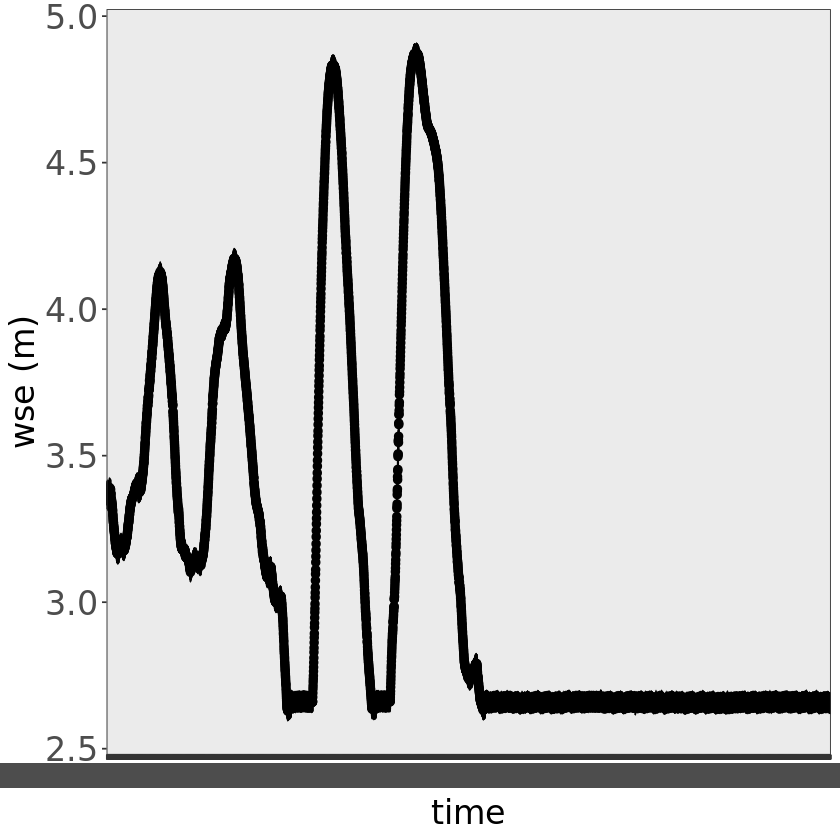

In [41]:
# stopCluster(cl)
library(dplyr)
library(ggplot2)
test1=read.csv('/nas/cee-water/cjgleason/calval/Processed data/UMass/Data frames/reprocessed_2023_08_30/node/CR_2135422PT_node_wse.csv')
test2=read.csv('/nas/cee-water/cjgleason/calval/Processed data/UMass/Data frames/reprocessed_2023_08_30/node/CR_2135424PT_node_wse.csv')
test3=read.csv('/nas/cee-water/cjgleason/calval/Processed data/UMass/Data frames/reprocessed_2023_08_30/node/CR_2135425PT_node_wse.csv')
test4=read.csv('/nas/cee-water/cjgleason/calval/Processed data/UMass/Data frames/reprocessed_2023_08_30/node/CR_2135426PT_node_wse.csv')
test5=read.csv('/nas/cee-water/cjgleason/calval/Processed data/UMass/Data frames/reprocessed_2023_08_30/node/CR_2135427PT_node_wse.csv')

bigdf=rbind(test2)#%>%
#filter(pt_time_UTC == '2023-04-25 19:00:00')

head(bigdf)
p1=ggplot(bigdf,aes(x=pt_time_UTC)) +
geom_point(aes(y=mean_node_pt_wse_m),size=2)+
  geom_errorbar(aes(ymin=mean_node_pt_wse_m-sigma_pt_correction_m-mean_pt_wse_precision_m,
                    ymax=mean_node_pt_wse_m+sigma_pt_correction_m+mean_pt_wse_precision_m), width=5,
                )+
 ylab('wse (m)')+
    xlab("time")+
    # ylim(c(0,1))+
   # coord_cartesian(ylim=c(-5, 1))+
      theme_bw() +

     # scale_y_continuous(breaks=seq(1,18))+
      theme(legend.text=element_text(size=20),
        legend.title=element_blank(),
            
        #legend.position =c(0.8,0.8),
        axis.text.y= element_text(size=20),
        #legend.position = 'none',
        axis.text.x =element_text(size=20),
        #axis.text.x=element_blank(),
        axis.title.x= element_text(size=20),
            axis.title.y= element_text(size=20),
        #panel.grid.major = element_line(colour = "grey50"),
        plot.title = element_text(color="black", size=12, face="bold.italic")) 
       # legend.background = element_rect(fill=alpha('white',0.8)))
        #axis.text.x = element_text(angle =45, vjust = 1, hjust=1))  


plot(p1)


,X,gnss_Lat,gnss_Lon,gnss_wse,gnss_time_tai,gnss_uncertainty_m,gnss_surf_flag,gnss_motion_flag,height_above_ellipsoid,gnss_time_UTC,gnss_ellipsoid,drift_id
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>
1,12482,42.25766,-72.61314,31.20135,734119000,0.02828714,12,2,1.751355,2023-04-06 17:56:03,"6378137,0.00335281066474748",Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv
2,12483,42.25766,-72.61314,31.19730,734119001,0.02828495,12,2,1.747284,2023-04-06 17:56:04,"6378137,0.00335281066474748",Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv
3,12484,42.25765,-72.61315,31.19454,734119002,0.02828275,12,2,1.744509,2023-04-06 17:56:05,"6378137,0.00335281066474748",Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv
4,12485,42.25764,-72.61316,31.19489,734119003,0.02828056,12,2,1.744839,2023-04-06 17:56:06,"6378137,0.00335281066474748",Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv
5,12486,42.25763,-72.61317,31.20462,734119004,0.02827837,12,2,1.754554,2023-04-06 17:56:07,"6378137,0.00335281066474748",Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv
6,12487,42.25763,-72.61317,31.20512,734119005,0.02827618,12,2,1.755037,2023-04-06 17:56:08,"6378137,0.00335281066474748",Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv


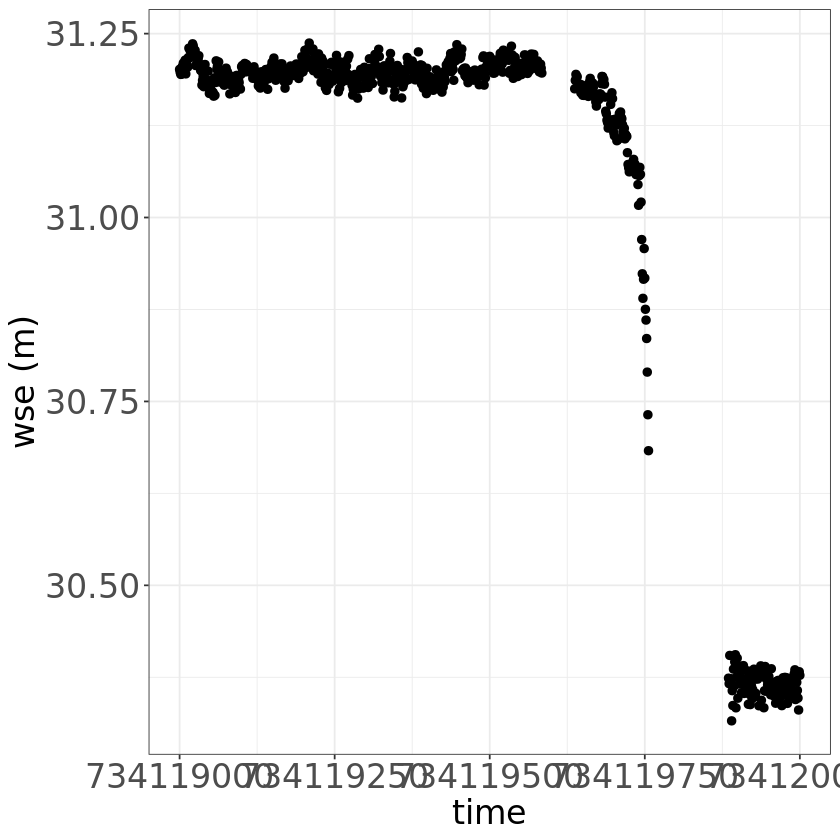

In [7]:
# stopCluster(cl)
library(dplyr)
library(ggplot2)
test1=read.csv('/nas/cee-water/cjgleason/calval/Processed data/UMass/Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv')

bigdf=rbind(test1)%>%
filter(gnss_time_tai >= 734119000)%>%
filter(gnss_time_tai <= 734120000)

head(bigdf)
p1=ggplot(bigdf,aes(x=gnss_time_tai)) +
geom_point(aes(y=gnss_wse),size=2)+

 ylab('wse (m)')+
    xlab("time")+
    # ylim(c(0,1))+
   # coord_cartesian(ylim=c(-5, 1))+
      theme_bw() +

     # scale_y_continuous(breaks=seq(1,18))+
      theme(legend.text=element_text(size=20),
        legend.title=element_blank(),
            
        #legend.position =c(0.8,0.8),
        axis.text.y= element_text(size=20),
        #legend.position = 'none',
        axis.text.x =element_text(size=20),
        #axis.text.x=element_blank(),
        axis.title.x= element_text(size=20),
            axis.title.y= element_text(size=20),
        #panel.grid.major = element_line(colour = "grey50"),
        plot.title = element_text(color="black", size=12, face="bold.italic")) 
       # legend.background = element_rect(fill=alpha('white',0.8)))
        #axis.text.x = element_text(angle =45, vjust = 1, hjust=1))  


plot(p1)


,reach_id,mean_reach_drift_wse_m,mean_reach_drift_wse_precision_m,wse_drift_start_UTC,wse_drift_end_UTC,reach_drift_slope_m_m,reach_drift_slope_precision_m,drift_id,ellipsoid_height_m,date
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<date>
1,7.312e+10,30.86268,0.05,2023-04-06 17:12:16,2023-04-06 18:51:41,-1.144155e-04,2.131701e-06,Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv,1.395383,2023-04-06
2,7.312e+10,32.00246,0.05,2023-04-06 15:34:44,2023-04-06 17:23:51,-7.106329e-05,1.990846e-06,Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv,2.662601,2023-04-06
3,7.312e+10,32.50869,0.05,2023-04-06 14:36:41,2023-04-06 16:25:21,-5.369564e-05,2.191460e-06,Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv,3.199378,2023-04-06
4,7.312e+10,33.43427,0.05,2023-04-06 13:19:22,2023-04-06 15:02:19,-8.954578e-05,1.011843e-05,Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230406T121431_20230406T194618_20230413T004702_1.csv,4.162126,2023-04-06
5,7.312e+10,32.40944,0.05,2023-04-18 15:34:35,2023-04-18 16:55:31,-5.551134e-05,4.738026e-06,Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230418T143021_20230418T173736_20230426T001634_1.csv,3.132674,2023-04-18
6,7.312e+10,33.13872,0.05,2023-04-18 15:53:35,2023-04-18 16:29:11,-7.546213e-05,6.391675e-06,Munged drifts/reprocessed_2023_08_30/SWOTCalVal_CR_GNSS_L2_Rec1_20230418T143021_20230418T173736_20230426T001634_1.csv,3.993493,2023-04-18


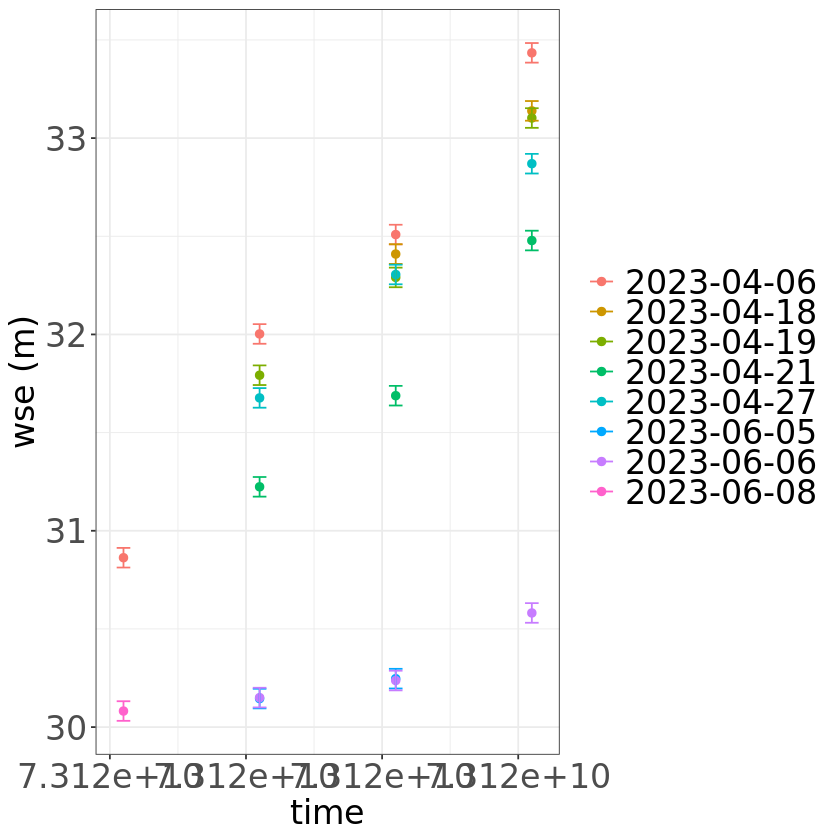

In [20]:
# stopCluster(cl)
library(dplyr)
library(ggplot2)
test1=read.csv('/nas/cee-water/cjgleason/calval/Processed data/UMass/Data frames/reprocessed_2023_08_30/reach/CR_drift_reach_wse_slope.csv')

bigdf=rbind(test1)%>%
mutate(date=as.Date(wse_drift_start_UTC))%>%
filter(mean_reach_drift_wse_m>25)

head(bigdf)
p1=ggplot(bigdf,aes(x=reach_id,col=as.factor(date))) +
geom_point(aes(y=mean_reach_drift_wse_m),size=2)+
  geom_errorbar(aes(ymin=mean_reach_drift_wse_m-0.05,
                    ymax=mean_reach_drift_wse_m+0.05), width=1,
                )+

 ylab('wse (m)')+
    xlab("time")+
    # ylim(c(0,1))+
   # coord_cartesian(ylim=c(-5, 1))+
      theme_bw() +

     # scale_y_continuous(breaks=seq(1,18))+
      theme(legend.text=element_text(size=20),
        legend.title=element_blank(),
            
        #legend.position =c(0.8,0.8),
        axis.text.y= element_text(size=20),
        #legend.position = 'none',
        axis.text.x =element_text(size=20),
        #axis.text.x=element_blank(),
        axis.title.x= element_text(size=20),
            axis.title.y= element_text(size=20),
        #panel.grid.major = element_line(colour = "grey50"),
        plot.title = element_text(color="black", size=12, face="bold.italic")) 
       # legend.background = element_rect(fill=alpha('white',0.8)))
        #axis.text.x = element_text(angle =45, vjust = 1, hjust=1))  


plot(p1)


In [11]:
library(dplyr)
test=read.csv('/nas/cee-water/cjgleason/calval/Processed data/CU/Data frames/reprocessed_2023_08_30/reach/WM_78220000211_PT_reach_wse.csv')%>%
group_by(nodelist)%>%
mutate(times_appearing = n())%>%
ungroup()%>%
print(nrow(.))%>%
filter(times_appearing == max(times_appearing))

head(test)
print(nrow(test))

# A tibble: 6,268 × 8
   pt_time_UTC         mean_reach_wse_m    reach_id mean_reach_pt_wse_m
   <chr>                          <dbl>       <dbl>               <dbl>
 1 2023-03-28 14:00:00             51.7 78220000211                51.7
 2 2023-03-28 14:15:00             51.7 78220000211                51.7
 3 2023-03-28 14:30:00             51.7 78220000211                51.7
 4 2023-03-28 14:45:00             51.7 78220000211                51.7
 5 2023-03-28 15:00:00             51.7 78220000211                51.7
 6 2023-03-28 15:15:00             51.7 78220000211                51.7
 7 2023-03-28 15:30:00             51.7 78220000211                51.7
 8 2023-03-28 15:45:00             51.7 78220000211                51.7
 9 2023-03-28 16:00:00             51.7 78220000211                51.7
10 2023-03-28 16:15:00             51.7 78220000211                51.7
   mean_reach_pt_wse_precision_m
                           <dbl>
 1                         0.026
 2             

pt_time_UTC,mean_reach_wse_m,reach_id,mean_reach_pt_wse_m,mean_reach_pt_wse_precision_m,nodelist,mean_p_dist_out,times_appearing
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>
2023-04-03 07:00:00,52.30499,7.822e+10,52.30499,0.026,78220000210491_78220000210371_78220000210231_78220000210091_78220000210011,372403.6,3597
2023-04-03 07:15:00,52.30639,7.822e+10,52.30639,0.026,78220000210491_78220000210371_78220000210231_78220000210091_78220000210011,372403.6,3597
2023-04-03 07:30:00,52.30759,7.822e+10,52.30759,0.026,78220000210491_78220000210371_78220000210231_78220000210091_78220000210011,372403.6,3597
2023-04-03 07:45:00,52.31039,7.822e+10,52.31039,0.026,78220000210491_78220000210371_78220000210231_78220000210091_78220000210011,372403.6,3597
2023-04-03 08:00:00,52.31099,7.822e+10,52.31099,0.026,78220000210491_78220000210371_78220000210231_78220000210091_78220000210011,372403.6,3597
2023-04-03 08:15:00,52.31139,7.822e+10,52.31139,0.026,78220000210491_78220000210371_78220000210231_78220000210091_78220000210011,372403.6,3597


[1] 3597
